In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# 데이터 불러오기
data = pd.read_csv('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/데이콘 빅데이터 분석/data/한국전력거래소_시간별 신재생에너지 거래량_20220331.csv',encoding='cp949')

In [2]:
# '거래일' 열을 datetime 형식으로 변환
data['거래일'] = pd.to_datetime(data['거래일'])

# '거래일' 열을 float 형식으로 변환 (시간 차이를 일 단위로 변환)
reference_date = data['거래일'].min()
data['거래일'] = (data['거래일'] - reference_date).dt.total_seconds() / (24 * 3600)

In [3]:
# 필요한 상수 및 하이퍼파라미터 정의
embedding_size = 128  # 임베딩 크기
num_nodes = 64  # LSTM 노드 수
batch_size = 32  # 배치 크기
num_unrollings = 10  # unrolling 수

# 데이터셋 분할 (학습 데이터와 테스트 데이터)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]


In [4]:
# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = num_unrollings
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(71855, 10, 11) (71855, 11)
(17957, 10, 11) (17957, 11)


In [6]:
class BatchGenerator(object):
    def __init__(self, data, batch_size, num_unrollings):
        self.data = data
        self.batch_size = batch_size
        self.num_unrollings = num_unrollings
        self.data_len = len(data)
        segment = self.data_len // batch_size
        self.cursor = [offset * segment for offset in range(batch_size)]
        self.last_batch = self._next_batch()

    def _next_batch(self):
        batch = np.zeros((self.batch_size, self.num_unrollings, self.data.shape[1]))
        for b in range(self.batch_size):
            for u in range(self.num_unrollings):
                batch[b, u] = self.data.iloc[self.cursor[b]]
                self.cursor[b] = (self.cursor[b] + 1) % self.data_len
        return batch
    
    def next(self):
        batches = [self.last_batch]
        for step in range(self.num_unrollings):
            batches.append(self._next_batch())
        self.last_batch = batches[-1]
        return batches

# BatchGenerator 사용 예제
batch_size = 32
num_unrollings = 10

# BatchGenerator 인스턴스 생성
train_generator = BatchGenerator(train_data, batch_size, num_unrollings)

# 배치 생성 예제
example_batches = train_generator.next()
for i, batch in enumerate(example_batches):
    print(f"Batch {i} shape: {batch.shape}")

Batch 0 shape: (32, 10, 11)
Batch 1 shape: (32, 10, 11)
Batch 2 shape: (32, 10, 11)
Batch 3 shape: (32, 10, 11)
Batch 4 shape: (32, 10, 11)
Batch 5 shape: (32, 10, 11)
Batch 6 shape: (32, 10, 11)
Batch 7 shape: (32, 10, 11)
Batch 8 shape: (32, 10, 11)
Batch 9 shape: (32, 10, 11)
Batch 10 shape: (32, 10, 11)


In [11]:
# 필요하지 않은 열 제거 (예: '거래일', '거래시간' 제외)
features = ['거래일', '거래시간', '연료전지', '석탄가스화복합화력(IGCC)', '태양광', '풍력', '수력', '해양에너지', '바이오에너지', '폐기물에너지', '신재생 합계']
data = data[features]

In [7]:
# 임베딩 크기(Embedding Size) 정의
embedding_size = 128  # 각 특징을 고차원 공간에 매핑할 때 사용하는 벡터의 크기

# LSTM 노드 수 정의
num_nodes = 64  # 각 LSTM 레이어에서 사용할 노드(유닛)의 수

# Dropout 확률 정의
keep_prob_train = 0.5  # 학습 시 50%의 노드를 비활성화하여 과적합 방지
keep_prob_sample = 1.0  # 검증 시 dropout을 사용하지 않음

# 기타 하이퍼파라미터
batch_size = 32  # 한 번에 모델에 입력으로 들어가는 데이터의 샘플 수
num_unrollings = 10  # LSTM이 한 번에 처리할 시퀀스의 길이

# TensorFlow 버전 확인 (선택 사항)
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.16.1


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# 하이퍼파라미터 정의
embedding_size = 128
num_nodes = 64
keep_prob_train = 0.5
keep_prob_sample = 1.0
batch_size = 32
num_unrollings = 10
num_features = len(features)

# TensorFlow 모델 정의
class RenewableEnergyModel(tf.keras.Model):
    def __init__(self, num_nodes, embedding_size, num_features, dropout_rate):
        super(RenewableEnergyModel, self).__init__()
        self.embedding = Dense(embedding_size, activation='relu')
        self.lstm1 = LSTM(num_nodes, return_sequences=True)
        self.lstm2 = LSTM(num_nodes)
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(num_features)
    
    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.dense(x)

# 입력 형태 정의
inputs = Input(shape=(num_unrollings, num_features))
model = RenewableEnergyModel(num_nodes, embedding_size, num_features, keep_prob_train)
outputs = model(inputs)

# 모델 컴파일
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# 모델 요약 출력
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ renewable_energy_model_3        │ (None, 11)             │        84,683 │
│ (RenewableEnergyModel)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,683 (330.79 KB)

 Trainable params: 84,683 (330.79 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import tensorflow as tf

class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(CustomLSTMCell, self).__init__()
        self.num_units = num_units
        self.state_size = [self.num_units, self.num_units]  # (hidden state, cell state)
        self.output_size = self.num_units

    def build(self, input_shape):
        self.input_dim = input_shape[-1]

        # LSTM 가중치 및 바이어스 초기화
        self.W_xi = self.add_weight(shape=(self.input_dim, self.num_units), initializer='random_normal', name='W_xi')
        self.W_hi = self.add_weight(shape=(self.num_units, self.num_units), initializer='random_normal', name='W_hi')
        self.b_i = self.add_weight(shape=(self.num_units,), initializer='zeros', name='b_i')

        self.W_xf = self.add_weight(shape=(self.input_dim, self.num_units), initializer='random_normal', name='W_xf')
        self.W_hf = self.add_weight(shape=(self.num_units, self.num_units), initializer='random_normal', name='W_hf')
        self.b_f = self.add_weight(shape=(self.num_units,), initializer='zeros', name='b_f')

        self.W_xc = self.add_weight(shape=(self.input_dim, self.num_units), initializer='random_normal', name='W_xc')
        self.W_hc = self.add_weight(shape=(self.num_units, self.num_units), initializer='random_normal', name='W_hc')
        self.b_c = self.add_weight(shape=(self.num_units,), initializer='zeros', name='b_c')

        self.W_xo = self.add_weight(shape=(self.input_dim, self.num_units), initializer='random_normal', name='W_xo')
        self.W_ho = self.add_weight(shape=(self.num_units, self.num_units), initializer='random_normal', name='W_ho')
        self.b_o = self.add_weight(shape=(self.num_units,), initializer='zeros', name='b_o')

    def call(self, inputs, states):
        h, c = states

        # 입력 게이트 계산
        i = tf.sigmoid(tf.matmul(inputs, self.W_xi) + tf.matmul(h, self.W_hi) + self.b_i)

        # 포겟 게이트 계산
        f = tf.sigmoid(tf.matmul(inputs, self.W_xf) + tf.matmul(h, self.W_hf) + self.b_f)

        # 셀 상태 업데이트
        c_new = f * c + i * tf.tanh(tf.matmul(inputs, self.W_xc) + tf.matmul(h, self.W_hc) + self.b_c)

        # 출력 게이트 계산
        o = tf.sigmoid(tf.matmul(inputs, self.W_xo) + tf.matmul(h, self.W_ho) + self.b_o)

        # 새로운 출력 계산
        h_new = o * tf.tanh(c_new)

        return h_new, [h_new, c_new]

# 모델 정의
class RenewableEnergyModel(tf.keras.Model):
    def __init__(self, num_nodes, embedding_size, num_features, dropout_rate):
        super(RenewableEnergyModel, self).__init__()
        self.embedding = Dense(embedding_size, activation='relu')
        self.lstm1 = tf.keras.layers.RNN(CustomLSTMCell(num_nodes), return_sequences=True)
        self.lstm2 = tf.keras.layers.RNN(CustomLSTMCell(num_nodes))
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(num_features)
    
    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.dense(x)

# 입력 형태 정의
inputs = Input(shape=(num_unrollings, num_features))
model = RenewableEnergyModel(num_nodes, embedding_size, num_features, keep_prob_train)
outputs = model(inputs)

# 모델 컴파일
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# 모델 요약 출력
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ renewable_energy_model_4        │ (None, 11)             │        84,683 │
│ (RenewableEnergyModel)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,683 (330.79 KB)

 Trainable params: 84,683 (330.79 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_data, num_unrollings)
X_test, y_test = create_sequences(test_data, num_unrollings)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(71855, 10, 11) (71855, 11)
(17957, 10, 11) (17957, 11)


In [29]:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.1)

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


Epoch 1/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 788021.6250 - val_loss: 1392974.3750
Epoch 2/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - loss: 672568.3125 - val_loss: 1260788.2500
Epoch 3/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 587970.6875 - val_loss: 1147270.8750
Epoch 4/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 509272.6562 - val_loss: 1045169.1875
Epoch 5/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 441343.0000 - val_loss: 951962.6875
Epoch 6/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 382575.9062 - val_loss: 867588.1250
Epoch 7/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 331884.4375 - val_loss: 791299.0000
Epoch 8/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 290878.6875 - val_loss: 722902.6875
Epoch 9/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 254077.7656 - val_loss: 661315.1250
Epoch 10/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 224100.6094 - val_loss: 604827.

562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


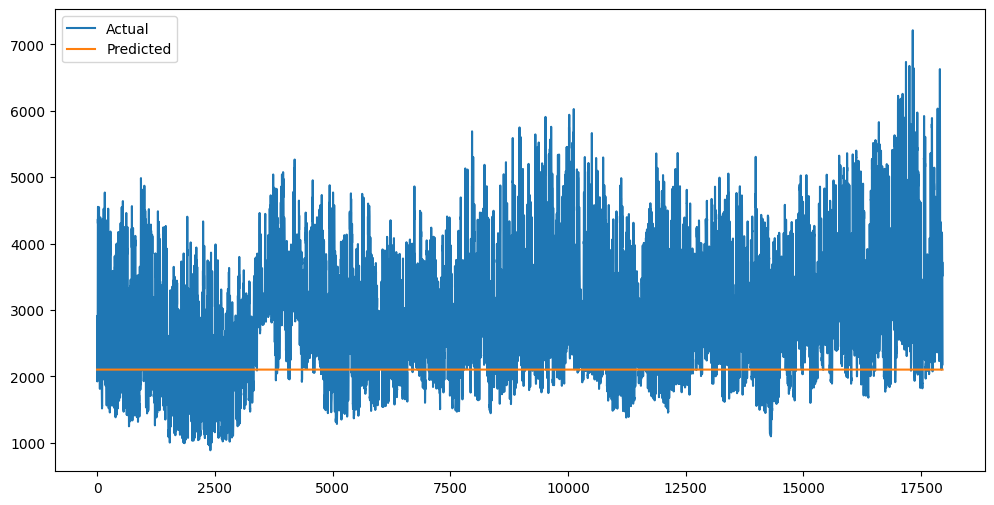

In [30]:
import matplotlib.pyplot as plt

# 예측 수행
predictions = model.predict(X_test)

# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(predictions[:, -1], label='Predicted')
plt.legend()
plt.show()
